In [4]:
import pandas as pd
import json as js
from glob import glob
import os
from main import make_parser
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
from scipy.stats import ttest_ind
from sklearn.decomposition import PCA
import gzip
from contrastive_data import *
from data_utils import *
from main import *
from models import *
from scoring import *
from glob import glob

In [44]:
path = 'models/KRAS_all_single/'
run_name = path.split('/')[-2]
run_name

'KRAS_all_single'

In [45]:
GENE = 'KRAS'
data_path = f'/home/lguirardel/data/perturb_comp/data/{GENE}/'
dir_name = path+'/KRAS_all_single_0' # for split


# Read records

In [46]:
parser = make_parser()
records = []
for p in glob(path+'*'):
    name = os.path.basename(p)
    filename = os.path.join(p, 'best_score.json')
    try:
        with open(filename) as reader:
            d = js.load(reader)
    except FileNotFoundError:
        d = {}
        print(p, ' Not found')
    cfg = vars(parser.parse_args(['.',name,'-c', os.path.join(p, 'config.ini')]))
    d.update(cfg)
    records.append(d)
results = pd.DataFrame.from_records(records)
results = results.drop(columns=['data_path','dest_name','verbose','restart', 'load_split','n_workers','overwrite','run_test','cpu', 'config_file', ])
results = results.drop(columns=['no_norm_embeds','group_synon','embed_dim', 'alpha'])
results = results.set_index('run_name').dropna(subset=['5_nn_ref_seen'])

In [47]:
results['n_layers'] = results['shape'].apply(lambda x : len(x))
results['hid_dim'] = results['shape'].apply(lambda x : x[0])

In [48]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
root = 'runs/'+'/'.join(path.split('/')[1:])
records = []
for file in glob(root+'/*'):
    event_acc = EventAccumulator(file)
    event_acc.Reload()
    name = os.path.basename(file)
    for tag in event_acc.Tags()['scalars']:
        for event in event_acc.Scalars(tag):
            records.append({'run_name': name, 'tag': tag, 'step': event.step, 'value': event.value})
    
full_scores = pd.DataFrame.from_records(records).dropna()

In [49]:
max_scores = full_scores[full_scores.tag.str.contains('nn')].groupby(['run_name','tag'])['value'].max().reset_index()
min_losses = full_scores[full_scores.tag.str.contains('loss')].groupby(['run_name','tag'])['value'].min().reset_index()
best = pd.concat([max_scores, min_losses])
best = best.set_index('run_name').pivot(columns='tag', values='value')
best = best.merge(results, left_index=True, right_index=True)

In [50]:
results.sort_values('5_nn_ref_seen', ascending=False).head(10)

,5_nn_ref_seen,i,loss,margin,dropout,weight_decay,batch_size,positive_fraction,shape,n_epochs,lr,scheduler,patience,cosine_t,task,knn,bag_size,mil_mode,n_layers,hid_dim
run_name,,,,,,,,,,,,,,,,,,,,
KRAS_all_single_71,0.064618,499,standard,1.0,0.150100,0.572054,512,0.440667,"[827, 827, 827]",600,0.000929,restarts,481,587,classifier,5,0,attention,3,827
KRAS_all_single_114,0.063769,432,standard,1.0,0.463071,0.797424,1024,0.443801,[657],600,0.000154,restarts,115,566,classifier,5,0,attention,1,657
KRAS_all_single_35,0.062799,4,standard,1.0,0.001372,0.000266,512,0.439326,[319],600,0.021614,plateau,20,433,classifier,5,0,attention,1,319
KRAS_all_single_40,0.062617,185,standard,1.0,0.454902,0.000532,128,0.535031,"[862, 862, 862, 862]",600,0.000054,plateau,289,357,classifier,5,0,attention,4,862
KRAS_all_single_26,0.061769,366,standard,1.0,0.091224,0.017079,1024,0.446527,"[797, 797, 797]",600,0.000572,restarts,245,250,classifier,5,0,attention,3,797
KRAS_all_single_19,0.061708,542,standard,1.0,0.136896,0.000069,512,0.431838,"[929, 929, 929, 929]",600,0.006226,restarts,123,193,classifier,5,0,attention,4,929
KRAS_all_single_121,0.061344,8,standard,1.0,0.331814,0.000056,1024,0.483898,[464],600,0.064728,restarts,169,587,classifier,5,0,attention,1,464
KRAS_all_single_82,0.061223,409,standard,1.0,0.164468,0.068112,512,0.467879,"[706, 706, 706]",600,0.008142,restarts,30,406,classifier,5,0,attention,3,706
KRAS_all_single_148,0.060981,29,standard,1.0,0.055879,0.000017,128,0.541687,"[805, 805]",600,0.000090,plateau,90,65,classifier,5,0,attention,2,805


# Read data

In [51]:
group_wt_like = False
paths = get_paths(data_path)
counts = load_data(*paths, group_wt_like=group_wt_like)

	Reading files...
		Reading matrix


		Reading genes and cells
		Reading variant data
	Merging and processing...
		97 variant classes


In [52]:
variant_data = pd.read_csv(paths[4], index_col=0)
variant_data.loc['control'] = pd.Series({'Control status':'synonymous','Variant functional class':'WT-like'})

In [53]:
with gzip.open(paths[3]) as file: # read cell tags
    v2c = pd.read_csv(file, sep='\t', usecols=['cell','variant'], index_col=1).squeeze()
v2c = v2c[counts.index]
v2c.shape

(87262,)

In [54]:
df_train, df_seen, df_unseen = load_split(join(dir_name, 'split'), counts, )
df_dict = {
    'train':df_train,
    'seen':df_seen,
    'unseen':df_unseen,
}

49491, 16497, 21274 exemples in data
73 variants in train
24 variants in unseen


In [55]:
pca = PCA(20)

In [56]:
red_dict = {}
for k, df in df_dict.items():
    with torch.no_grad():
        X = df.drop(columns=['variant','Variant functional class','cycle' ]).to_numpy() #(B, 1, 1, d)
        X_red = pca.fit_transform(X) if k == 'train' else pca.transform(X)

    # emb_dict[k] = (embeds - embeds.mean(dim=0, keepdim=True)) / embeds.norm(dim=0, keepdim=True) # no : we want plots to represent distances in embed space 
    red_dict[k] = X_red  

In [57]:
k=5
y_true = df_dict['seen']['variant'].to_numpy()

knn = KNeighborsClassifier(k)
knn.fit(red_dict['train'], df_dict['train']['variant'])

pca_ref_seen = accuracy_score(y_true, knn.predict(red_dict['seen']))

In [58]:
knn = KNeighborsTransformer(n_neighbors=k)
knn.fit(red_dict['seen'])
graph = knn.kneighbors_graph()
y_true = df_dict['seen']['variant'].cat.codes.to_numpy()

y_pred_pca = y_true[find(graph)[1]] # neighbors' y (find(graph)[1] are the target nodes in the knn graph)
y_pred_pca = y_pred_pca.reshape((-1, k)) # (kN, ) -> (N, k)
y_pred_pca = mode(y_pred_pca.T).mode
pca_self_seen = accuracy_score(y_true, y_pred_pca)

In [59]:
best.loc['pca'] = pd.Series({'test_seen/5_nn_ref': pca_ref_seen, 'task':'pca', 'test_seen/5_nn_self': pca_self_seen})

In [60]:
best

,test_seen/5_nn_ref,test_seen/5_nn_self,test_seen/loss,test_unseen/5_nn_self,test_unseen/loss,train/5_nn_self,train/loss,5_nn_ref_seen,i,loss,...,lr,scheduler,patience,cosine_t,task,knn,bag_size,mil_mode,n_layers,hid_dim
run_name,,,,,,,,,,,,,,,,,,,,,
KRAS_all_single_0,0.050494,0.046978,6.827410,0.115399,6.892572,0.050939,6.833733,0.050494,5.0,standard,...,0.000917,plateau,124.0,380.0,batch-supervised,5.0,0.0,attention,1.0,116.0
KRAS_all_single_1,0.054555,0.047403,7.455517,0.117326,7.612115,0.835223,7.368593,0.054555,8.0,standard,...,0.004168,plateau,160.0,85.0,batch-supervised,5.0,0.0,attention,1.0,403.0
KRAS_all_single_10,0.057586,0.044857,3.654638,0.116339,NaN,0.999030,0.000699,0.057586,5.0,standard,...,0.029756,restarts,77.0,86.0,classifier,5.0,0.0,attention,2.0,471.0
KRAS_all_single_100,0.050312,0.042250,0.015473,0.110699,0.044786,0.052575,0.016202,0.050312,397.0,standard,...,0.000562,restarts,22.0,473.0,siamese,5.0,0.0,attention,4.0,623.0
KRAS_all_single_101,0.060799,0.045099,3.685673,0.116903,NaN,0.984502,0.048126,0.060799,488.0,standard,...,0.004166,restarts,252.0,235.0,classifier,5.0,0.0,attention,3.0,791.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KRAS_all_single_96,0.047887,0.041826,0.016774,0.107878,0.046260,0.049888,0.016766,0.047887,560.0,standard,...,0.005850,restarts,345.0,64.0,siamese,5.0,0.0,attention,4.0,797.0
KRAS_all_single_97,0.056010,0.048797,3.650932,0.121228,NaN,0.146208,2.583083,0.056010,12.0,standard,...,0.002084,plateau,86.0,175.0,classifier,5.0,0.0,attention,1.0,48.0
KRAS_all_single_98,0.059465,0.048372,3.668788,0.121792,NaN,0.206421,2.974515,0.059465,149.0,standard,...,0.049135,plateau,382.0,356.0,classifier,5.0,0.0,attention,1.0,810.0


In [61]:
# results = results[results.task!='cycle-classifier']

# Plots

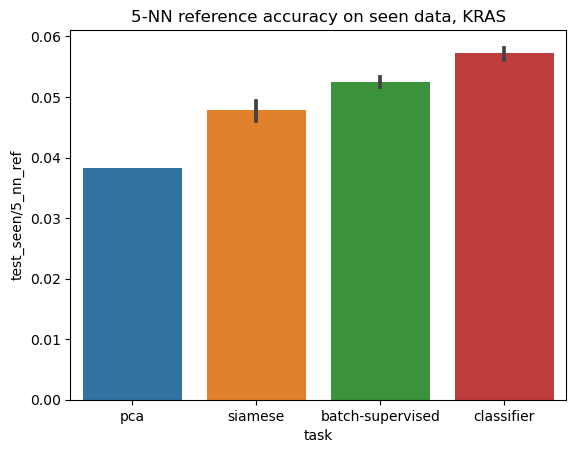

In [62]:
sns.barplot(data=best, x='task', y = 'test_seen/5_nn_ref', order=['pca','siamese','batch-supervised','classifier'] )
plt.title(f'5-NN reference accuracy on seen data, {GENE}')
plt.savefig(f'plots/scores/5_nn_ref_seen_{GENE}.pdf')

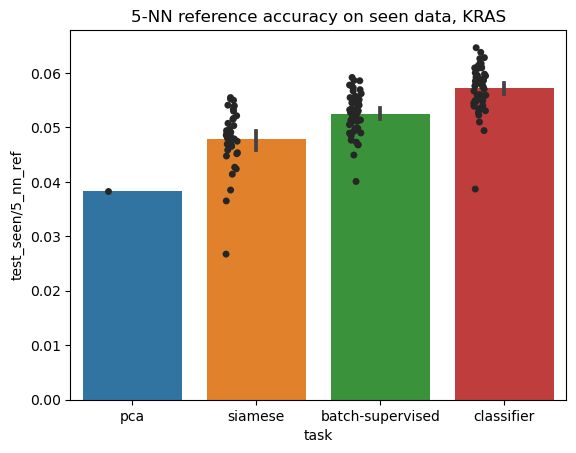

In [63]:
sns.barplot(data=best, x='task', y = 'test_seen/5_nn_ref', order=['pca','siamese','batch-supervised','classifier'] )
sns.stripplot(data=best, x='task', y = 'test_seen/5_nn_ref', order=['pca','siamese','batch-supervised','classifier'], 
        hue=True, hue_order=[True,False], dodge=True, legend=False,
         color='k', alpha=1)
plt.title(f'5-NN reference accuracy on seen data, {GENE}')
plt.savefig(f'plots/scores/5_nn_ref_seen_{GENE}_strip.pdf')

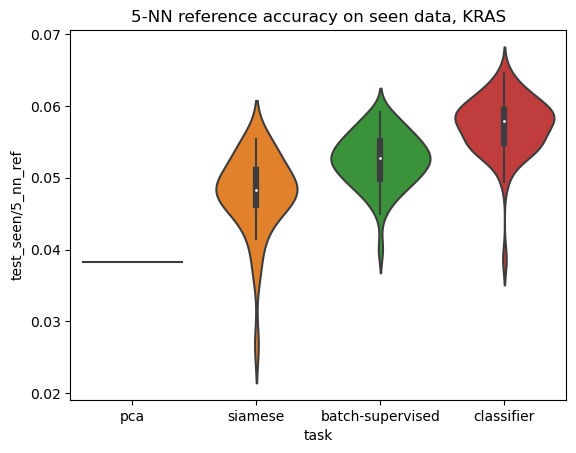

In [64]:
sns.violinplot(data=best, x='task', y = 'test_seen/5_nn_ref', order=['pca','siamese','batch-supervised','classifier'] )
# sns.stripplot(data=best, x='task', y = 'test_seen/5_nn_ref', order=['pca','siamese','batch-supervised','classifier'], 
#         hue=True, hue_order=[True,False], dodge=True, legend=False,
#          color='k', alpha=1)

plt.title(f'5-NN reference accuracy on seen data, {GENE}')
plt.savefig(f'plots/scores/5_nn_ref_seen_{GENE}_violin.pdf')

In [65]:
results.groupby('task').size()

task
batch-supervised    56
classifier          59
siamese             39
dtype: int64

<Axes: >

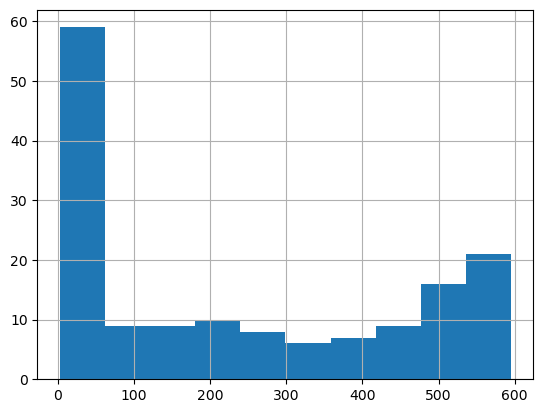

In [66]:
results.i.hist()

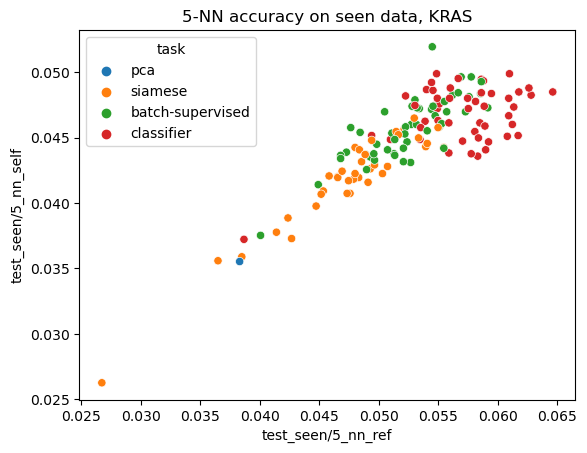

In [67]:
df = best.sample(frac=1).groupby('task').head(50)
sns.scatterplot(x=df['test_seen/5_nn_ref'],y=df['test_seen/5_nn_self'],hue=df['task'],
                hue_order=['pca','siamese','batch-supervised','classifier'] )
plt.title(f'5-NN accuracy on seen data, {GENE}')
plt.savefig(f'plots/scores/score_ref_vs_self_{GENE}.pdf')

In [68]:
!ls -d runs/TP53_all_single/TP53_siam* |wc -l

46
